In [9]:
# ==========================================
# 1. SETUP & IMPORTS
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [10]:
# ==========================================
# 2. DATA LOADING & EDA
# ==========================================
# Load the reliable built-in dataset
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Price'] = data.target  # Target is in $100,000s

print(f"Dataset Loaded: {df.shape[0]} rows, {df.shape[1]} columns")

Dataset Loaded: 20640 rows, 9 columns


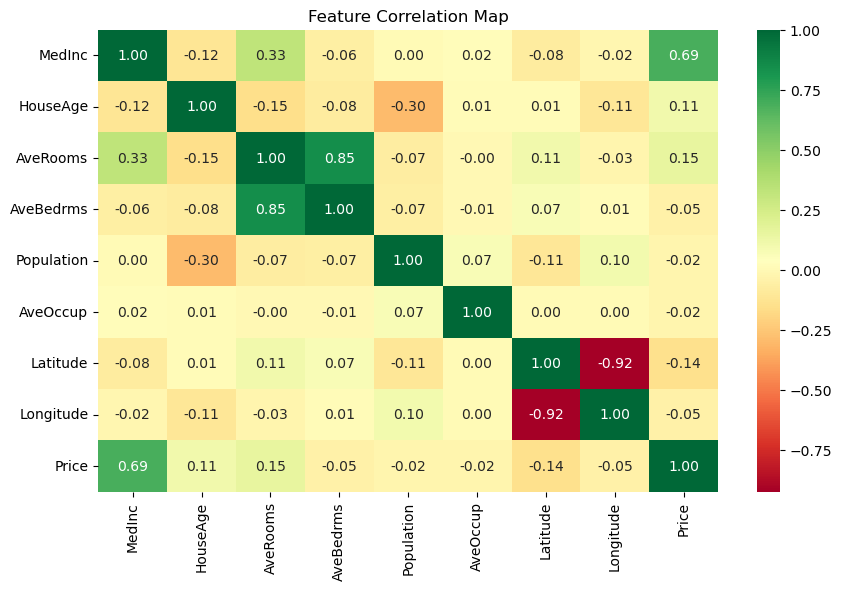

In [11]:
# Visualizing Correlation
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn', fmt='.2f')
plt.title("Feature Correlation Map")
plt.show()

In [12]:
# ==========================================
# 3. PREPROCESSING PIPELINE
# ==========================================
X = df.drop('Price', axis=1)
y = df['Price']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline to handle missing values and scaling automatically
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), X.columns)
    ])

In [13]:
# ==========================================
# 4. MODEL TRAINING & HYPERPARAMETER TUNING
# ==========================================
# Define the XGBoost Pipeline
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Define the grid of parameters to test
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 6],
    'regressor__learning_rate': [0.1, 0.05]
}

print("Starting Hyperparameter Tuning... (this may take a moment)")
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Best Parameters Found: {grid_search.best_params_}")

Starting Hyperparameter Tuning... (this may take a moment)
Best Parameters Found: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__n_estimators': 200}



--- MODEL PERFORMANCE ---
RMSE: $46,387.00
R2 Score: 0.8358


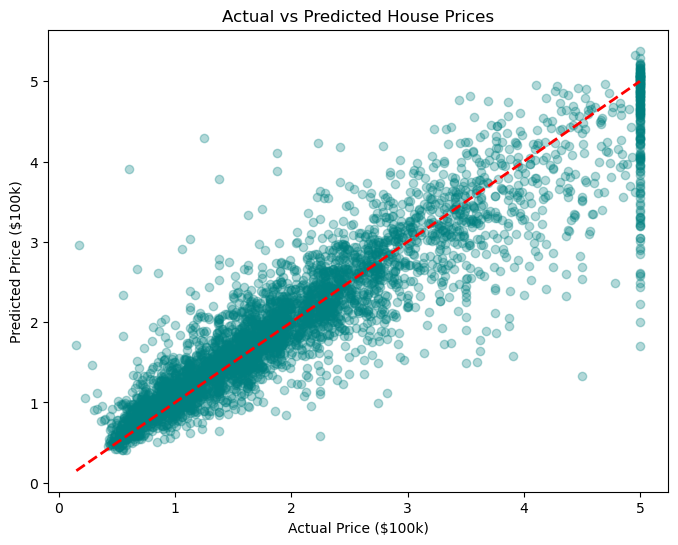

In [14]:
# ==========================================
# 5. EVALUATION
# ==========================================
predictions = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print(f"\n--- MODEL PERFORMANCE ---")
print(f"RMSE: ${rmse * 100000:,.2f}") # Converting back to actual dollars
print(f"R2 Score: {r2:.4f}")

# Plotting Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.3, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price ($100k)')
plt.ylabel('Predicted Price ($100k)')
plt.title('Actual vs Predicted House Prices')
plt.show()

In [15]:
# ==========================================
# 6. MINI COMMAND-LINE INTERFACE (CLI)
# ==========================================
def house_price_bot():
    print("\n--- House Price Prediction Bot ---")
    print("Enter 'exit' to stop.")
    
    # Using average values as a shortcut for the user input demo
    try:
        # For demonstration, we'll predict based on a sample from the test set
        idx = int(input(f"Enter a house ID (0 to {len(X_test)-1}): "))
        sample = X_test.iloc[[idx]]
        actual = y_test.iloc[idx]
        
        pred = best_model.predict(sample)[0]
        
        print(f"\nResults for House #{idx}:")
        print(f"Predicted Value: ${pred * 100000:,.2f}")
        print(f"Actual Value:    ${actual * 100000:,.2f}")
        print(f"Difference:      ${abs(pred-actual) * 100000:,.2f}")
    except:
        print("Invalid input. Please enter a number.")

house_price_bot()


--- House Price Prediction Bot ---
Enter 'exit' to stop.


Enter a house ID (0 to 4127):  3333



Results for House #3333:
Predicted Value: $502,435.88
Actual Value:    $500,001.00
Difference:      $2,434.87
